![](https://www.microsoft.com/en-us/research/uploads/prod/2018/08/SCS-MS-Research_20180816_1400x788_DoWhy_T2-5b7b4771617f2-1024x576.png)

# Introduction

### What is causal inference?

Causal inference is the process of reasoning that an action caused an outcome. It is inferring the effect of one thing (treatment/intervention/policy) on another thing. E.g. I missed the train, because I arrived to the station late. We could say I arrived late because I am generally a tardy person, but for the sake of practicality, we are not going to be looking at causality in a [philosophical sense](https://plato.stanford.edu/entries/causation-metaphysics/) in this notebook.                           

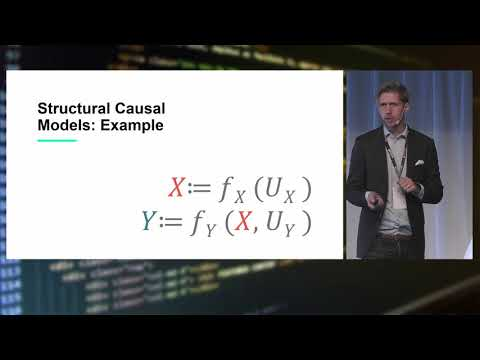

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('dFp2Ou52-po', start=17, width=560, height=315)

### Why do we need it?

Statistical inference and machine learning models are great at finding correlations in the data but may not always find the real causes for outcomes. Think of the use of feature importance methods like [SHAP](https://www.kaggle.com/dansbecker/shap-values) and how well they can identify the most important features in a dataset. From a decision-making standpoint, features with the highest importance scores may not always be the best to act on or may not even affect the outcome at all. Causal inference helps us understand the why.

### Difficulties of causal inference

A common problem with causal analysis throughout most sciences is that it requires experimentation which is not possible on observational data. This would require us to act one way and observe the consequences, and then go back in time and act another way to observe how the results may have been different. This is the fundamental problem with causal inference [[1](https://www.cambridge.org/core/journals/ps-political-science-and-politics/article/abs/can-big-data-solve-the-fundamental-problem-of-causal-inference/A6737446D01B322A5EC9B8F138242B74), [2](https://www.sciencedirect.com/topics/social-sciences/causal-inference#:~:text=The%20fundamental%20problem%20for%20causal,potential%20outcome%20under%20the%20other)]. In simple terms:
- We can only observe something that actually occures, whatever causes it to occur - the **factual**
- A treatment or decision (T0) causes an effect (Y) to occur if, and only if, changing T0 causes a change in Y. The causal effect is the magnitude of change in Y by a unit change in T.
- We can never observe some other treatment or decision made (T0) to cause a different effect on Y - the **counterfactual**
- Thus, 1) we can never directly calculate the counterfactual's effect, 2) must resort to estimations and 3) expect some challenges when doing validation

### Methodology

[Judea Pearl](https://en.wikipedia.org/wiki/Judea_Pearl) sets forth a [four steps process](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2836213/#__sec17title) in his seminal work, based on the Structural Causal Model (SCM):
> 1. *Define: Express the target quantity Q as a function Q(M) that can be computed from any model M.*
> 2. *Assume: Formulate causal assumptions using ordinary scientific language and represent their structural part in graphical form.*
> 3. *Identify: Determine if the target quantity is identifiable (i.e., expressible in terms of estimable parameters).*
> 4. *Estimate: Estimate the target quantity if it is identifiable, or approximate it, if it is not. Test the statistical implications of the model, if any, and modify the model when failure occurs.*

### DoWhy

In this notebook, we are going to be using the [DoWhy](https://microsoft.github.io/dowhy/) python library which allows us to do causal inference in a few simple lines of code. According to the documentation:

> *While many methods exist for causal inference, it is hard to compare their assumptions and robustness of results. DoWhy makes three contributions,*
> 1. *Provides a principled way of modeling a given problem as a causal graph so that all assumptions are explicit.*
> 2. *Provides a unified interface for many popular causal inference methods, combining the two major frameworks of graphical models and potential outcomes.*
> 3. *Automatically tests for the validity of assumptions if possible and assesses the robustness of the estimate to violations.*

DoWhy also breaks this down into 4 steps: 

1. **Modeling:** Create a causal graph to encode assumptions.
2. **Identification:** Formulate what to estimate.
3. **Estimation:** Compute the estimate.
4. **Refutation:** Validate the assumptions.

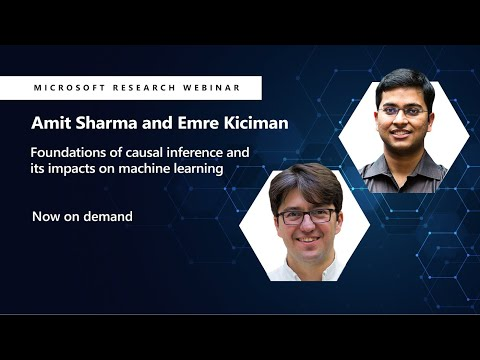

In [14]:
YouTubeVideo('LALfQStONEc', start=1019, width=560, height=315)

In [2]:
pip install dowhy==0.8

  Using cached dowhy-0.8-py3-none-any.whl (287 kB)
  Attempting uninstall: dowhy
    Found existing installation: dowhy 0.7
    Uninstalling dowhy-0.7:
      Successfully uninstalled dowhy-0.7
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Creating a dataset

An example on how DoWhy can be used to estimate **the effect of a subscription or a rewards program for customers**.

Suppose that a website has **a membership rewards program** where customers receive additional benefits if they sign up. 

- How do we know if the program is effective? 

Here the relevant **causal** question is: 

- What is the impact of offering the membership rewards program on total sales? 

And the equivalent **counterfactual** question is, 

- If the current members had not signed up for the program, how much less would they have spent on the website?

In formal language, we are interested in the **Average Treatment Effect on the Treated (ATT)**.

# I. Formulating the causal model

Suppose that the rewards program was introduced in January 2019. The outcome variable is **the total spends at the end of the year**. We have data on all **monthly transactions** of every user and on **the time of signup** for those who chose to signup for the rewards program. Here’s what the data looks like.

In [4]:
# Creating some simulated data for our example
import pandas as pd
import numpy as np

num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up

df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})

# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0

# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10

# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100

In [5]:
df

,user_id,signup_month,month,spend,treatment
0,0,8,1,463,True
1,0,8,2,496,True
2,0,8,3,468,True
3,0,8,4,444,True
4,0,8,5,436,True
...,...,...,...,...,...
119995,9999,7,8,492,True
119996,9999,7,9,511,True
119997,9999,7,10,524,True
119998,9999,7,11,499,True


Post-process the data based on the graph and the month of the treatment (signup).

For each customer, determine their average monthly spend before and after month `i`.


---
**The importance of time** 

Time plays a crucial role in modeling this problem.

Rewards signup can affect the future transactions, but not those that happened before it. In fact, the transactions prior to the rewards signup can be assumed to cause the rewards signup decision. Therefore we split up the variables for each user:

- Activity prior to the treatment (assumed a cause of the treatment)
- Activity after the treatment (is the outcome of applying treatment)

Of course, many important variables that affect signup and total spend are missing (e.g., the type of products bought, length of a user’s account, geography, etc.). This is a critical assumption in the analysis, one that needs to be tested later using refutation tests.


---


Below is the causal graph for a user who signed up in month `i=3`. The analysis will be similar for any `i`.

In [6]:
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In [7]:
# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
df_i_signupmonth

,user_id,signup_month,treatment,pre_spends,post_spends
0,1,0,False,478.5,417.111111
1,2,0,False,477.0,411.000000
2,4,0,False,479.0,404.888889
3,5,0,False,477.0,427.888889
4,7,0,False,497.0,426.333333
...,...,...,...,...,...
5412,9991,0,False,502.5,417.888889
5413,9993,0,False,494.0,419.888889
5414,9995,0,False,494.0,406.666667
5415,9997,0,False,501.5,423.222222


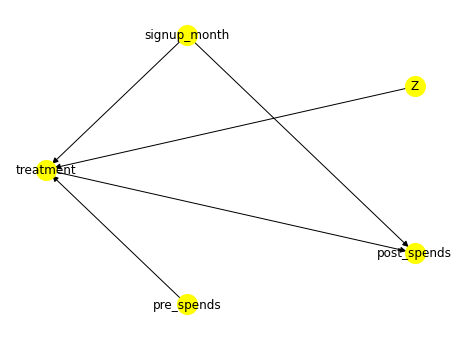

In [8]:
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()

In [9]:
# from IPython.display import Image, display
# display(Image(filename="causal_model.png"))

More generally, we can include any activity data for the customer in the above graph. All prior- and post-activity data will occupy the same place (and have the same edges) as the Amount spent node (prior and post respectively).

# II. Identifying the causal effect

For the sake of this example, let us assume that unobserved confounding does not play a big part.

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[Z  pre_spends]              ⎝d[Z  pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z,pre_spends})
Estimand assumption 2, Exclusion: If we remove {Z,pre_spends}→{treatment}, then ¬({Z,pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Based on the graph, DoWhy determines that the signup month and amount spent in the pre-treatment months (signup_month, pre_spend) needs to be conditioned on.

# III. Estimating the effect

We now estimate the effect based on the backdoor estimand, setting the target units to “att”.

In [11]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                 target_units="att")
print(estimate)

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 109.0245775729646



The analysis tells us the **Average Treatment Effect on the Treated (ATT)**. That is, the average effect on total spend for the customers that signed up for the Rewards Program in month i=3 (compared to the case where they had not signed up). We can similarly calculate the effects for customers who signed up in any other month by changing the value of i(line 2 above) and then rerunning the analysis.

Note that the estimation suffers from **left and right-censoring**. 

1. **Left-censoring**: If a customer signs up in the first month, we do not have enough transaction history to match them to similar customers who did not sign up (and thus apply the backdoor identified estimand). 
2. **Right-censoring**: If a customer signs up in the last month, we do not enough future (post-treatment) transactions to estimate the outcome after signup.

Thus, even if the effect of signup was the same across all months, the estimated effects may be different by month of signup, due to lack of data (and thus high variance in estimated pre-treatment or post-treatment transactions activity).

# IV. Refuting the estimate

We refute the estimate using **the placebo treatment refuter**. This refuter substitutes the treatment by an independent random variable and checks whether our estimate now goes to zero (it should!).

In [12]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate, 
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", 
                                   num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:109.0245775729646
New effect:2.076856118791605
p value:0.2815782953372983



# References

This notebook draws heavily from [this](https://www.youtube.com/watch?v=LALfQStONEc&t=1019s) webinar and follows a [case study](https://www.pywhy.org/dowhy/v0.9.1/example_notebooks/dowhy_example_effect_of_memberrewards_program.html) in the documentation.

Amit Sharma, Emre Kiciman, et al. DoWhy: A Python package for causal inference. 2019. https://github.com/microsoft/dowhy